## 목차
### 1. 얼굴이 포함된 사진 준비
### 2. 얼굴의 bounding box 찾아낸 이후 얼굴 영역 face landmark 찾아내기
### 3. 찾아진 영역의 얼굴에 고양이 수염 이미지 붙이기

# STEP 1 : 스티커 구하기 or 만들기
### (스티커 사진을 제외한 모든 사진은 픽사베이에서 가져왔습니다)
### /aiffel/camera_sticker/images/front - 정면 사진
### /aiffel/camera_sticker/images/cat - 고양이 수염 이미지

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("import 완료했습니다")

import 완료했습니다


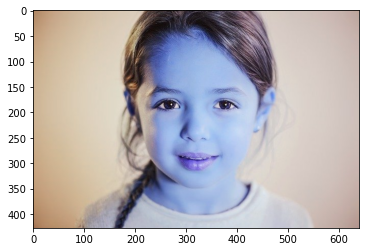

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/images/front.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

### 사진의 색상이 푸르게 보이는 것은 opencv의 특징 때문입니다.
### matplotlib, dlib 등의 이미지는 RGB(빨,녹,파) 채널을 사용합니다.
### 그러나 opencv BGR(파,녹,빨) 순으로 사용합니다.
### 그렇기에 원본 사진의 빨->파, 파->빨으로 보입니다.¶
### 그래서 이 다음에 plt.imshow를 하기 전에 RGB 이미지로 바꾸어야 합니다.

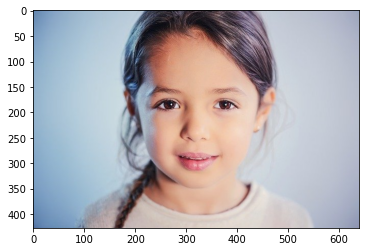

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# STEP 2 : 얼굴 검출 & 랜드마크 검출 하기

### Object detection기술을 이용해서 얼굴의 위치를 찾습니다.
### dlib의 face detector은 HOG와 SVM을 사용해서 얼굴을 찾을 수 있습니다.
### HOG : 이미지에서 색상의 변화량을 나타냅니다.
### SVM : 선형 분류기 (한 이미지를 다차원 공간의 벡터라고 보면 여러 이미지는 여러 벡터로, 이 것을 구분 짓는 방법임. 여기서는 얼굴이냐 아니냐)
### 그러나 이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못합니다.
### 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동합니다.
### sliding window를 이용해서 얼굴의 위치를 찾을 수 있습니다.
### 큰 이미지의 작은 영역(window)를 잘라 얼굴이 있는지 확인하고 없으면 그 옆으로 옮겨 얼굴이 있는지 확인하는 것입니다. -> 하지만 이미지가 크면 클수록 오래걸립니다.
### =>이것이 딥러닝이 필요해지는 이유입니다.

In [4]:
detector_hog = dlib.get_frontal_face_detector()
print("dlib을 활용해 hog detector를 선언했습니다")

dlib을 활용해 hog detector를 선언했습니다


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print("detector_hog를 이용해 얼굴의 bounding box 추출 완료!")

detector_hog를 이용해 얼굴의 bounding box 추출 완료!


rectangles[[(216, 118) (439, 341)]]


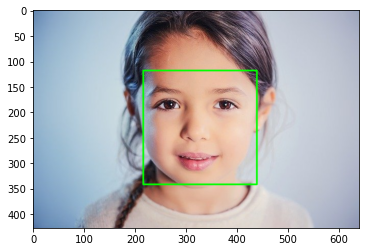

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("landmark모델을 불러왔습니다.")

landmark모델을 불러왔습니다.


In [8]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


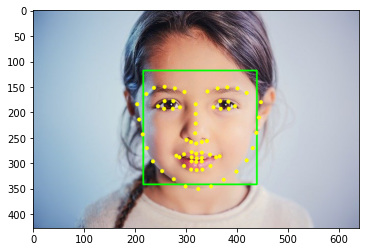

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 4, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# STEP 3 : 스티커 적용 위치 확인하기

In [10]:
#좌표확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(318, 241)
(x,y) : (318,129)
(w,h) : (224,224)


### 해당 사진의 코의 중심점은 (300, 232)입니다.

In [11]:
#고양이 수염 이미지를 불러오고 위에 단계에서 계산한 크기로 resize하기
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


# STEP 4 : 스티커 적용하기

In [12]:
refined_x = x - w 
refined_y = y - h //2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (94,17)


### y축 좌표의 값이 음수로 나옵니다.
### 그 이유는 스티커의 시작점이 얼굴 영역을 벗어났기 때문입니다.
### opencv데이터는 numpy ndarray 형태의 데이터를 사용하나 이것은 음수 인덱스에 접근 할 수 없기 때문에 예외 처리를 해줘야 합니다.

In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (94,17)


### -y만큼 스티커를 자르고 top의 x,y좌표를 각각의 경우에 맞춰서 원본 이미지의 경계값으로 수정하면 됩니다 

In [14]:
# mg_show[from:to] 형식을 이용합니다.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("원본 이미지에 스티커를 적용했습니다.")

원본 이미지에 스티커를 적용했습니다.


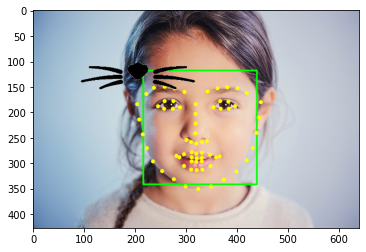

In [15]:
#결과 이미지를 출력합니다.
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 문제 발생!
### 해당 부분에서 스티커가 원하는 위치와는 다른 곳에 있습니다.
### 위치를 변경해야 합니다. -> STEP 4의 처음으로 돌아갑니다.

### bounding box의 왼쪽 위 꼭짓점이 0이고, 사진의 위로 올라가면 갈 수록 y가 음수가 됩니다.
### 그렇다는 것은 x축 y축이 거꾸로 뒤집힌 모양이라는 뜻입니다.
### 또한, 우리는 고양이 수염이 코 한가운데에 오기를 원하기 때문에 높이를 빼면 안됩니다.
### => 고양이 수염이 아래로 이동합니다
### 마지막으로 수염을 오른쪽으로 이동(코로) 시켜야 되기 때문에 나누기 2를 해줍니다

In [16]:
refined_x = x - w //2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (206,129)


In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("원본 이미지에 스티커를 다시 적용했습니다.")

원본 이미지에 스티커를 다시 적용했습니다.


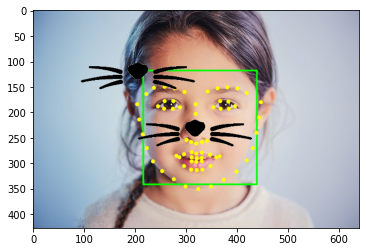

In [18]:
#결과 이미지를 다시 출력합니다.
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

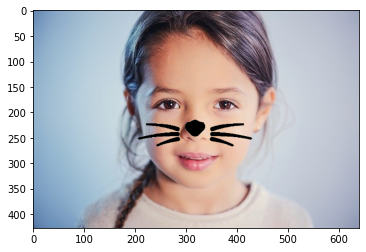

In [19]:
# bounding box와 landmark를 제거합니다.
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 완성!!!
### 하지만 다른 각도 / 밝기 / 촬영거리에서도 적용이 되는지 확인을 해야됩니다.

## (1) 얼굴각도가 다른 사진을 불러오고 고양이 수염 스티커 붙여보기

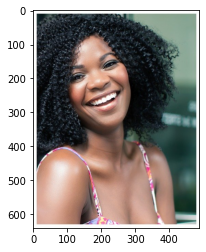

In [20]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/images/angle.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(92, 118) (315, 341)]]


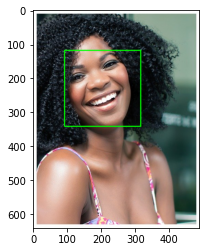

In [21]:
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


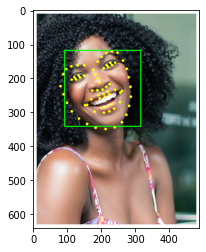

In [22]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 4, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [23]:
#좌표확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(195, 213)
(x,y) : (195,101)
(w,h) : (224,224)


In [24]:
refined_x = x - w //2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (83,101)


원본 이미지에 스티커를 적용했습니다.


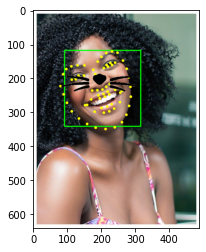

In [25]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("원본 이미지에 스티커를 적용했습니다.")
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴의 각도를 구하기

In [26]:
import math
def get_num():
    x_a = h
    y_a = 0
    x_b = x
    y_b = y+dlib_rect.height()*2
    return [x_a,y_a,x_b,y_b]
def cal_rad(arr):
    rad = math.atan2(arr[3]-arr[1],arr[2]-arr[0])
    return rad
def radTodeg(rad):
    PI = math.pi
    deg = (rad*180)/PI
    angel="{0:0.2f}".format(deg)
    print(angel)
arr=get_num()
rad=cal_rad(arr)
radTodeg(rad)

93.02


In [27]:
from PIL import Image
img=cv2.imread(sticker_path)
img_rotate_angle_clockwise=cv2.rotate(img, cv2.ROTATE_angle_CLOCKWISE)

AttributeError: module 'cv2.cv2' has no attribute 'ROTATE_angle_CLOCKWISE'

### 나름대로 찾아보았으나 왜 사진이 적용이 안되는지 모르겠네요...

## (2) 밝은 이미지 사진을 불러오고 고양이 수염 스티커 붙여보기

In [ ]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/images/brightness.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 너무 밝은 사진의 경우, bounding box가 인식이 안됩니다.

In [ ]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/camera_sticker/images/distance.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 1, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
#좌표확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

In [ ]:
refined_x = x - w //2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("원본 이미지에 스티커를 적용했습니다.")
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 너무 거리가 먼 사진의 경우, bounding box와 landmark가 인식은 되나 스티커가 오히려 커서 적용이 불가능합니다.

# REPORT
### 3-5까지 밖에 안되서 쉽게 생각했는데, 생각보다 너무 어려웠습니다.
### 여러가지 사진을 구해서 시도를 해봤으나, 수염이 있는 경우에는 얼굴보다 긴 부분을 인식을 해서 스티커를 적용시키는데 어려움을 겪었습니다.
### 처음에 스티커를 적용시키는 부분에서 'x = landmark[30][0]과  y = landmark[30][1] - dlib_rect.height()//2'부분이 이해가 안되었습니다만, 성돈님의 도움으로 이해를 할 수 있었습니다. (저는 [30]이 코 부분을 뜻하는 것은 이해가 되었지만 [0]과 [1]이 무엇인지 알지 못했습니다.)
### 각도가 다른 사진의 경우에는 1. 사진의 각도를 구하고, 2. 스티커를 해당 각도에 맞춰서 돌리면 적용이 가능하지 않을까 했는데, 생각보다 쉽지 않았습니다. 열심히 구글링을 해서 적용해 봤으나 오류가 났습니다.. 혹시 어떻게 해결하는지 아신다면 알려주세요...
### 밝은 사진은 bounding box가 인식되지 않았습니다.
### 너무 거리가 먼 사진의 경우, bounding box와 landmark가 인식은 되나 스티커가 오히려 커서 맞지 않았습니다. (계산식도 안 맞았습니다)